# RPS Classify MONAI Pytorch
This notebook referred to MONAI's Image Classification Tutorial with the MedNIST Dataset<br/>
https://colab.research.google.com/drive/1wy8XUSnNWlhDNazFdvGBHLfdkGvOHBKe

## Install MONAI

In [1]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

In [2]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report

import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

#print_config()

## Read image filenames from the dataset folders

In [3]:
data_dir = '../input/rockpaperscissors' 
class_names = ['paper','rock','scissors']
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
               for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]


In [4]:
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

In [5]:
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 2188
Image dimensions: 300 x 200
Label names: ['paper', 'rock', 'scissors']
Label counts: [712, 726, 750]


## Visualise some examples

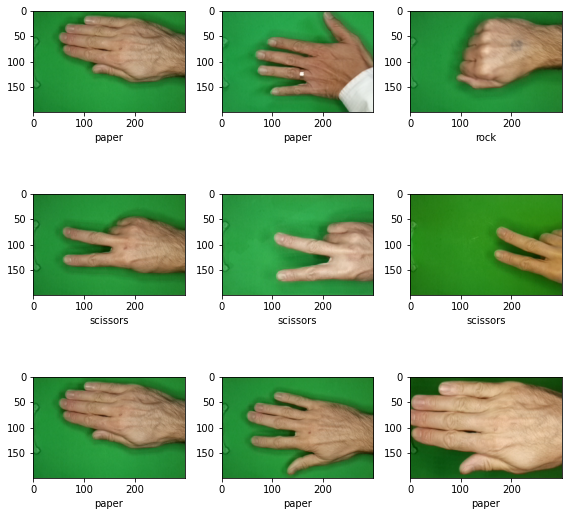

In [6]:
plt.subplots(3,3, figsize=(8,8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3,3, i+1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists

In [7]:
valid_frac, test_frac = 0.1, 0.1
trainX,trainY = [],[]
valX,valY = [],[]
testX,testY = [],[]

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print(len(trainX),len(valX),len(testX))

1729 212 247


In [8]:
trainX=np.array(trainX)
trainY=np.array(trainY)
valX=np.array(valX)
valY=np.array(valY)
testX=np.array(testX)
testY=np.array(testY)

## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [9]:
class SumDimension(Transform):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)

In [10]:
train_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    SumDimension(3),
    #RandRotate(range_x=15, prob=0.5, keep_size=True),
    #RandFlip(spatial_axis=0, prob=0.5),
    #RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor(),
])

val_transforms = Compose([
    LoadImage(image_only=True),
    AddChannel(),
    ScaleIntensity(),
    SumDimension(3),
    ToTensor(),
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=num_class)

In [11]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [12]:
train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, num_workers=2)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=2)

In [13]:
device = torch.device("cuda:0")   #"cuda:0"
model = DenseNet121(
    spatial_dims=2,            
    in_channels=1,
    out_channels=num_class,
).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 10
val_interval = 1

In [14]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)     ##### 
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
                
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
                
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
            
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


----------
epoch 1/10
1/27, train_loss: 1.1029
2/27, train_loss: 1.0969
3/27, train_loss: 1.0748
4/27, train_loss: 1.1059
5/27, train_loss: 1.0709
6/27, train_loss: 1.0733
7/27, train_loss: 1.0668
8/27, train_loss: 1.0515
9/27, train_loss: 1.0324
10/27, train_loss: 1.0454
11/27, train_loss: 0.9969
12/27, train_loss: 1.0025
13/27, train_loss: 1.0123
14/27, train_loss: 0.9690
15/27, train_loss: 0.9996
16/27, train_loss: 0.9502
17/27, train_loss: 0.9980
18/27, train_loss: 0.9929
19/27, train_loss: 0.9249
20/27, train_loss: 0.9565
21/27, train_loss: 0.9139
22/27, train_loss: 0.9161
23/27, train_loss: 0.9383
24/27, train_loss: 0.9163
25/27, train_loss: 0.9085
26/27, train_loss: 0.8863
27/27, train_loss: 0.8945
28/27, train_loss: 1.1283
epoch 1 average loss: 1.0009
saved new best metric model
current epoch: 1 current AUC: 0.8748 current accuracy: 0.4764 best AUC: 0.4764 at epoch: 1
----------
epoch 2/10
1/27, train_loss: 0.8982
2/27, train_loss: 0.8731
3/27, train_loss: 0.8907
4/27, train_lo

## Plot the loss and metric

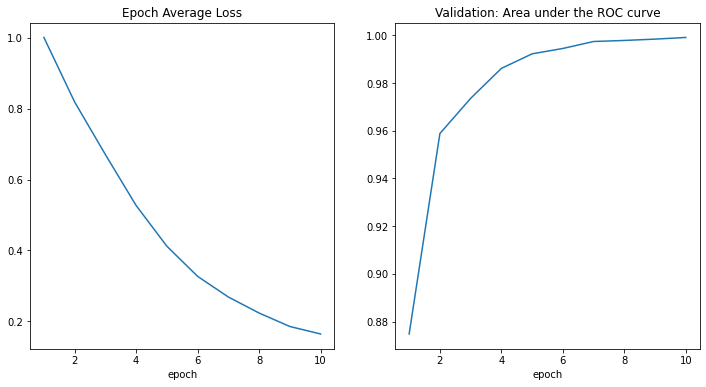

In [15]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

In [16]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [17]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

       paper     1.0000    0.9425    0.9704        87
        rock     0.8974    1.0000    0.9459        70
    scissors     0.9770    0.9444    0.9605        90

    accuracy                         0.9595       247
   macro avg     0.9581    0.9623    0.9589       247
weighted avg     0.9626    0.9595    0.9598       247

